# Score-Based Generative Modeling with Reverse-Time SDEs (3×3 Grid)

This notebook accompanies **Chapter 9, Section 9.1 (Score-Based Diffusion Models)**.

We implement a minimal **score-based diffusion** pipeline on a synthetic 3×3 Gaussian grid dataset:

1. **Data**: a mixture of Gaussians on a 3×3 grid (ground truth samples).
2. **Forward model**: a simple time-dependent diffusion (variance schedule / β-protocol).
3. **Training**: denoising score matching (DSM) to learn the score field \(\nabla_x \log p_t(x)\).
4. **Sampling**: simulate the **reverse-time SDE** using the learned score.

At the end, we generate two diagnostic figures saved to `figs/`:
- a **two-panel figure** comparing ground-truth vs generated samples and showing example **reverse trajectories**;
- a **multi-panel figure** illustrating the **time evolution of the learned score field**.


In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Ensure we save figures into figs/
os.makedirs("figs", exist_ok=True)


## 1. Ground-truth data: a 3×3 Gaussian grid

We create a simple 2D dataset consisting of a mixture of Gaussians whose means form a 3×3 grid.
This is a convenient toy distribution: it is multi-modal, non-trivial, and easy to visualize.


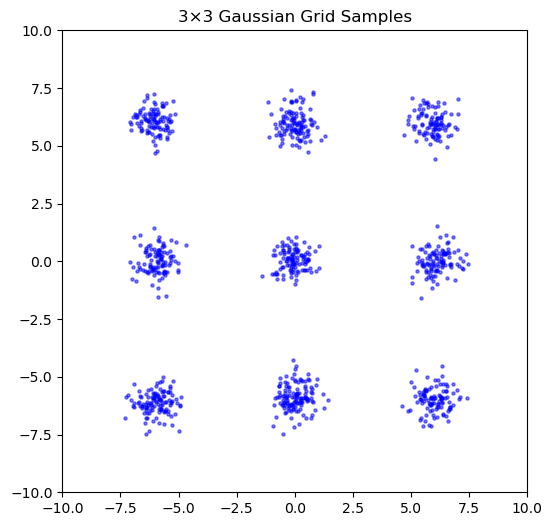

In [2]:
# ------------------------------
# 🎯 Generate 3×3 Gaussian Grid
# ------------------------------
def generate_gaussian_grid(n_samples, grid_size=3, spacing=6.0, std=0.5):
    """
    Generate a dataset from a mixture of Gaussians in a 3x3 grid.
    
    Args:
        n_samples: Total number of samples.
        grid_size: Number of Gaussians per row/column.
        spacing: Distance between Gaussian centers.
        std: Standard deviation of each Gaussian.

    Returns:
        torch.Tensor of shape (n_samples, 2).
    """
    centers = np.linspace(-spacing, spacing, grid_size)  # Grid centers
    means = np.array(np.meshgrid(centers, centers)).T.reshape(-1, 2)  # 9 Gaussian centers

    # Randomly assign samples to Gaussians
    assignments = np.random.choice(len(means), size=n_samples)

    # Generate Gaussian noise
    samples = np.random.randn(n_samples, 2) * std + means[assignments]

    return torch.tensor(samples, dtype=torch.float32)

# Generate and visualize samples
xtns = generate_gaussian_grid(1000)
dset = torch.utils.data.TensorDataset(xtns)

plt.figure(figsize=(6, 6))
plt.scatter(xtns[:, 0], xtns[:, 1], s=5, alpha=0.5, color='blue')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.title("3×3 Gaussian Grid Samples")
plt.savefig('figs/sbd_9grid_ground_truth-bis.png', dpi=200, bbox_inches='tight')
plt.show()

# ------------------------------

## 2. Score network

We train a small neural network \(s_\theta(x,t)\) to approximate the **score**:
\[
s(x,t) = \nabla_x \log p_t(x),
\]
i.e. the gradient of the log-density of the noised data distribution at time \(t\).


In [3]:
# 🏗️ Define Score Network
# ------------------------------
score_network = torch.nn.Sequential(
    torch.nn.Linear(3, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 2),
)

# ------------------------------

## 3. Denoising score matching (DSM) objective

We learn \(s_\theta\) by predicting the conditional score of a noised sample given the clean one.
This is the standard **DSM** training objective used in score-based diffusion.


In [4]:
# 🎯 Define Training Loss Function
# ------------------------------
def calc_loss(score_network: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    t = torch.rand((x.shape[0], 1), dtype=x.dtype, device=x.device) * (1 - 1e-4) + 1e-4
    int_beta = (0.1 + 0.5 * (20 - 0.1) * t) * t  # Integral of beta
    mu_t = x * torch.exp(-0.5 * int_beta)
    var_t = -torch.expm1(-int_beta)
    x_t = torch.randn_like(x) * var_t ** 0.5 + mu_t
    grad_log_p = -(x_t - mu_t) / var_t  

    xt = torch.cat((x_t, t), dim=-1)
    score = score_network(xt)
    
    loss = (score - grad_log_p) ** 2
    weighted_loss = var_t * loss
    return torch.mean(weighted_loss)

# ------------------------------

## 4. Training loop

We train the network over randomly sampled time points and noise realizations.


In [5]:
# 🏋️ Train the Model
# ------------------------------
import time
opt = torch.optim.Adam(score_network.parameters(), lr=3e-4)
dloader = torch.utils.data.DataLoader(dset, batch_size=256, shuffle=True)

t0 = time.time()
for i_epoch in range(150000):
    total_loss = 0
    for data, in dloader:
        opt.zero_grad()
        loss = calc_loss(score_network, data)
        loss.backward()
        opt.step()
        total_loss += loss.detach().item() * data.shape[0]
    
    if i_epoch % 10000 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dset)}")

# ------------------------------

0 (0.2487781047821045s): 1.1476258573532105
10000 (132.09736919403076s): 0.39306407475471494
20000 (261.8689510822296s): 0.3487770068645477
30000 (388.9443860054016s): 0.3553267331123352
40000 (516.5971839427948s): 0.3625661454200745
50000 (652.4547860622406s): 0.3623006498813629
60000 (783.9454960823059s): 0.3576336727142334
70000 (917.7715849876404s): 0.3967050144672394
80000 (1048.6686880588531s): 0.3600973596572876
90000 (1181.9165580272675s): 0.37452250814437865
100000 (1321.762665271759s): 0.3907340106964111
110000 (1455.206068277359s): 0.37740858149528506
120000 (1583.33096909523s): 0.3619836883544922
130000 (1714.9635083675385s): 0.36909719109535216
140000 (1857.3371272087097s): 0.36458279252052306


## 5. Reverse-time sampling

Once trained, we generate samples by integrating the **reverse-time SDE** from \(t=1\) down to \(t=0\).


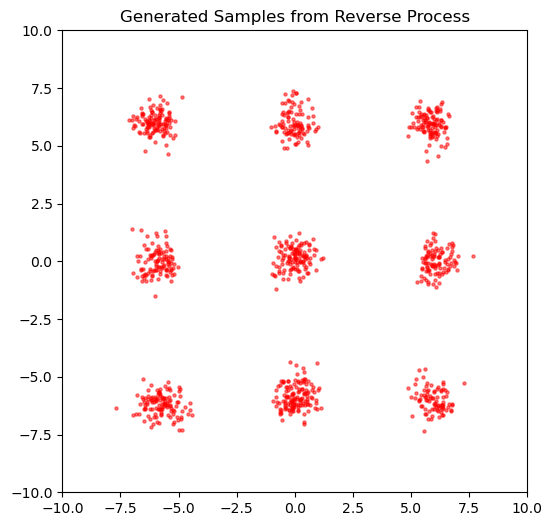

In [6]:
# 🔄 Reverse Process (Sampling)
# ------------------------------
# --- comments from Misha -- to implement U-turn we will need to modify this code. Change the time from [1\to 0] to [T_u\to 0] and
# and also replace initialization at T_u 
def generate_samples(score_network: torch.nn.Module, nsamples: int) -> torch.Tensor:
    x_t = torch.randn((nsamples, 2))  
    time_pts = torch.linspace(1, 0, 1000)
    beta = lambda t: 0.1 + (20 - 0.1) * t

    for i in range(len(time_pts) - 1):
        t = time_pts[i]
        dt = time_pts[i + 1] - t
        fxt = -0.5 * beta(t) * x_t
        gt = beta(t) ** 0.5
        score = score_network(torch.cat((x_t, t.expand(x_t.shape[0], 1)), dim=-1)).detach()
        drift = fxt - gt * gt * score
        diffusion = gt
        x_t = x_t + drift * dt + diffusion * torch.randn_like(x_t) * torch.abs(dt) ** 0.5

    return x_t

# Generate and plot synthetic samples
samples = generate_samples(score_network, 1000).detach()
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.5, color='red')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.title("Generated Samples from Reverse Process")
plt.savefig('figs/sbd_9grid_generated_only-bis.png', dpi=200, bbox_inches='tight')
plt.show()

/var/folders/s5/8pby83n5305c0l0dvb7d7p5c0000gr/T/ipykernel_11031/84349257.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", frameon=False)


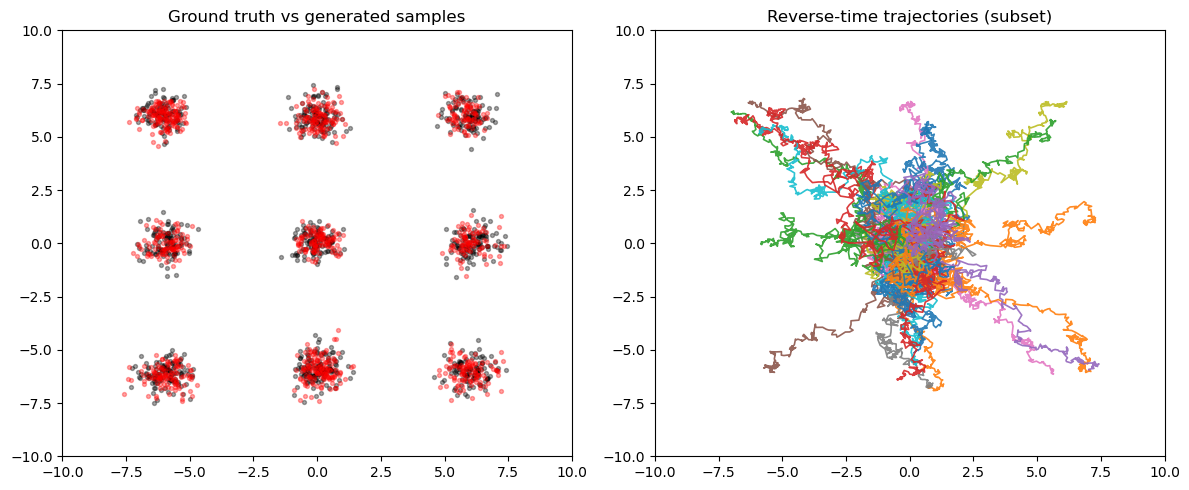

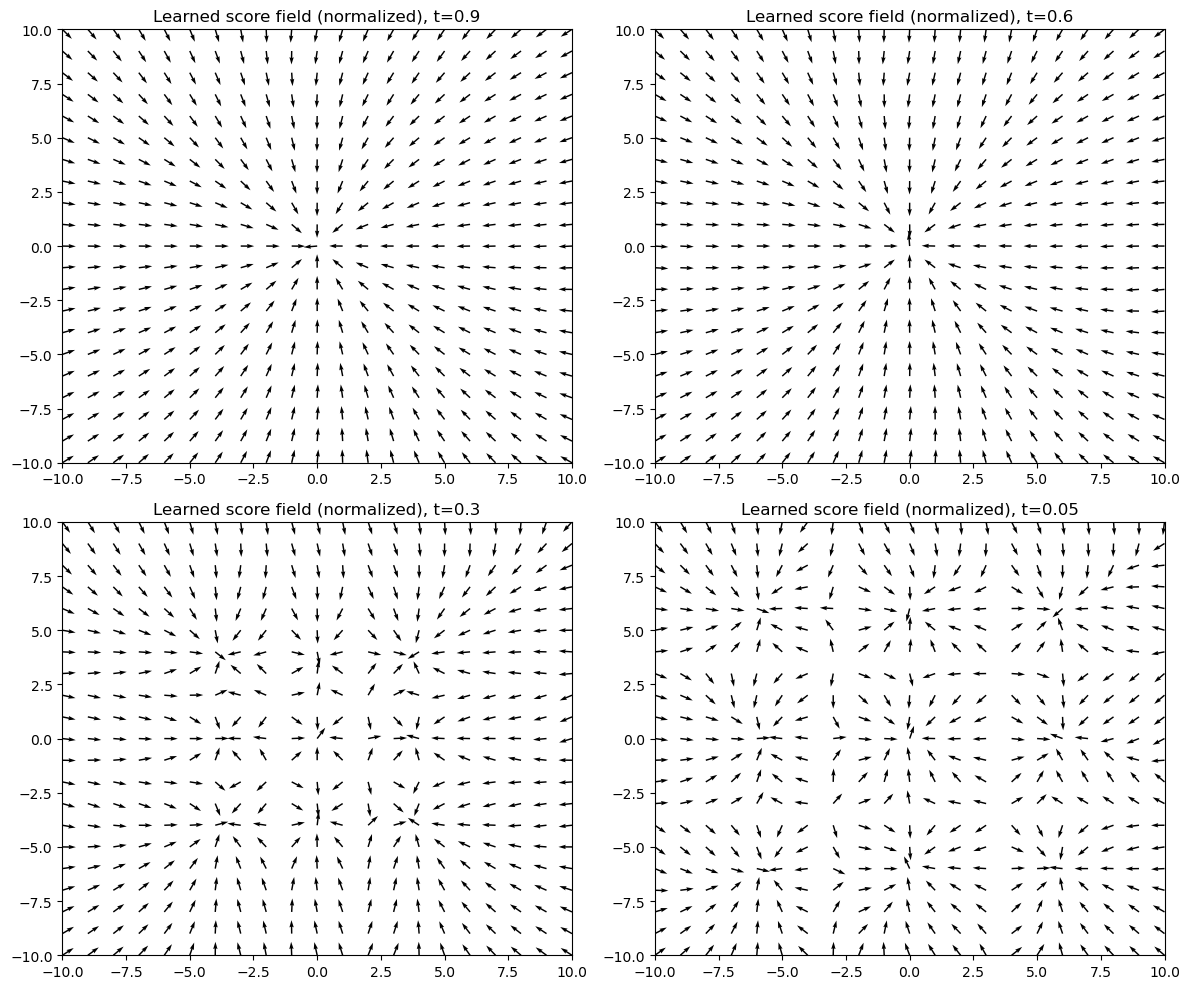

In [7]:
# ------------------------------
# 6. Diagnostics and figure export
# ------------------------------

@torch.no_grad()
def generate_samples_and_trajectories(score_network: torch.nn.Module,
                                      nsamples: int,
                                      n_traj: int = 25,
                                      n_steps: int = 400):
    """Generate samples and record a subset of reverse trajectories."""
    x_t = torch.randn((nsamples, 2))
    time_pts = torch.linspace(1, 0, n_steps)
    beta = lambda t: 0.1 + (20 - 0.1) * t

    traj = torch.zeros((n_steps, n_traj, 2))
    traj[0] = x_t[:n_traj]

    for i in range(n_steps - 1):
        t = time_pts[i]
        dt = time_pts[i + 1] - t

        fxt = -0.5 * beta(t) * x_t
        gt = beta(t) ** 0.5

        score = score_network(torch.cat((x_t, t.expand(x_t.shape[0], 1)), dim=-1))
        drift = fxt - gt * gt * score

        x_t = x_t + drift * dt + gt * torch.randn_like(x_t) * torch.abs(dt) ** 0.5

        traj[i + 1] = x_t[:n_traj]

    return x_t.detach(), traj.detach(), time_pts.detach()

# Re-generate samples + trajectories for diagnostics
samples_diag, traj, time_pts = generate_samples_and_trajectories(score_network, nsamples=1000, n_traj=25, n_steps=400)

# --- Figure 1: Two-panel diagnostics
plt.figure(figsize=(12, 5))

# Left: GT + generated overlay
plt.subplot(1, 2, 1)
plt.scatter(xtns[:, 0], xtns[:, 1], s=8, alpha=0.35, color="black")
plt.scatter(samples_diag[:, 0], samples_diag[:, 1], s=8, alpha=0.35, color="red")
plt.xlim(-10, 10); plt.ylim(-10, 10)
plt.title("Ground truth vs generated samples")
plt.legend(loc="upper right", frameon=False)

# Right: example reverse trajectories
plt.subplot(1, 2, 2)
for k in range(traj.shape[1]):
    xy = traj[:, k, :].cpu().numpy()
    plt.plot(xy[:, 0], xy[:, 1], linewidth=1.2, alpha=0.9)
plt.xlim(-10, 10); plt.ylim(-10, 10)
plt.title("Reverse-time trajectories (subset)")

plt.tight_layout()
plt.savefig("figs/sbd_9grid_diagnostics-bis.png", dpi=200, bbox_inches="tight")
plt.show()


# --- Figure 2: Score-field evolution (vector field snapshots)
@torch.no_grad()
def score_field_on_grid(score_network: torch.nn.Module, t: float, lim: float = 10.0, n: int = 21):
    xs = torch.linspace(-lim, lim, n)
    ys = torch.linspace(-lim, lim, n)
    X, Y = torch.meshgrid(xs, ys, indexing="xy")
    pts = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1)
    tt = torch.full((pts.shape[0], 1), float(t))
    sc = score_network(torch.cat([pts, tt], dim=1)).cpu().numpy()
    return X.cpu().numpy(), Y.cpu().numpy(), sc[:, 0].reshape(n, n), sc[:, 1].reshape(n, n)

times = [0.9, 0.6, 0.3, 0.05]
plt.figure(figsize=(12, 10))

for i, t in enumerate(times, start=1):
    X, Y, U, V = score_field_on_grid(score_network, t=t, lim=10.0, n=21)

    # Normalize for display (avoids arrows exploding at small t)
    norm = np.sqrt(U**2 + V**2) + 1e-8
    U_disp = U / norm
    V_disp = V / norm

    plt.subplot(2, 2, i)
    plt.quiver(X, Y, U_disp, V_disp, angles="xy")
    plt.xlim(-10, 10); plt.ylim(-10, 10)
    plt.title(f"Learned score field (normalized), t={t:g}")

plt.tight_layout()
plt.savefig("figs/sbd_9grid_score_field_evolution-bis.png", dpi=200, bbox_inches="tight")
plt.show()


## 7. Saving the trained model

Optionally save the trained score network weights for reuse.

In [8]:
torch.save(score_network.state_dict(), 'trained_score_model-bis.pt')
print('Saved: trained_score_model-bis.pt')

Saved: trained_score_model-bis.pt
